# Neural Networks and Deep Learning - Programming Assignment

## Import libraries

In [1]:
! pip3 install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [2]:
import torch
from torch import nn, utils
import numpy as np
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)

## DataLoader

In [3]:
# code in this cell is adapted from kentaroy47/vision-transformers-cifar10
# https://github.com/kentaroy47/vision-transformers-cifar10/blob/main/randomaug.py

"""
Define functions to apply a random selection of the following transformations to
training data:

- Shear (in x or y axis)
- Translate (in x or y axis)
- Rotate
- Auto Contrast
- Invert
- Equalize
- Solarize
- Posterize
- Contrast
- Color
- Brightness
- Sharpness
- Cutout

"""

import random

import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
import numpy as np
import torch
from PIL import Image


def ShearX(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v):  # [-0.3, 0.3]
    assert -0.3 <= v <= 0.3
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def TranslateXabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateYabs(img, v):  # [-150, 150] => percentage: [-0.45, 0.45]
    assert 0 <= v
    if random.random() > 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def Rotate(img, v):  # [-30, 30]
    assert -30 <= v <= 30
    if random.random() > 0.5:
        v = -v
    return img.rotate(v)


def AutoContrast(img, _):
    return PIL.ImageOps.autocontrast(img)


def Invert(img, _):
    return PIL.ImageOps.invert(img)


def Equalize(img, _):
    return PIL.ImageOps.equalize(img)


def Solarize(img, v):  # [0, 256]
    assert 0 <= v <= 256
    return PIL.ImageOps.solarize(img, v)


def SolarizeAdd(img, addition=0, threshold=128):
    img_np = np.array(img).astype(int)
    img_np = img_np + addition
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def Posterize(img, v):  # [4, 8]
    v = int(v)
    v = max(1, v)
    return PIL.ImageOps.posterize(img, v)


def Contrast(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Color(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Color(img).enhance(v)


def Brightness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Sharpness(img, v):  # [0.1,1.9]
    assert 0.1 <= v <= 1.9
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def CutoutAbs(img, v):  # [0, 60] => percentage: [0, 0.2]
    # assert 0 <= v <= 20
    if v < 0:
        return img
    w, h = img.size
    x0 = np.random.uniform(w)
    y0 = np.random.uniform(h)

    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = min(w, x0 + v)
    y1 = min(h, y0 + v)

    xy = (x0, y0, x1, y1)
    color = (125, 123, 114)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img

def Identity(img, v):
    return img

def augment_list():

    l = [
        (AutoContrast, 0, 1),
        (Equalize, 0, 1),
        (Invert, 0, 1),
        (Rotate, 0, 30),
        (Posterize, 0, 4),
        (Solarize, 0, 256),
        (SolarizeAdd, 0, 110),
        (Color, 0.1, 1.9),
        (Contrast, 0.1, 1.9),
        (Brightness, 0.1, 1.9),
        (Sharpness, 0.1, 1.9),
        (ShearX, 0., 0.3),
        (ShearY, 0., 0.3),
        (CutoutAbs, 0, 40),
        (TranslateXabs, 0., 100),
        (TranslateYabs, 0., 100),
        (Identity, 0., 0.)
    ]

    return l

class RandAugment:
    """
    Class handles which augmentations to apply to incoming image
    """
    def __init__(self, n, m):
        """
        n:
          The number of augmentations to apply to incoming image
        m:
          The strength of the augmentation applied
        """
        self.n = n
        self.m = m      # [0, 30]
        self.augment_list = augment_list()

    def __call__(self, img):
        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            val = (float(self.m) / 30) * float(maxval - minval) + minval
            img = op(img, val)

        return img

In [4]:
from torchvision.transforms import v2

"""
Load CIFAR 10 dataset.

Apply two random transformations from set of transformations defined above to
training data.

Do not apply transformations to test data.
"""

train_augmentation = transforms.Compose([
    RandAugment(2, 14),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

test_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train = CIFAR10(
    "/content/drive/MyDrive/ai-msc",
    train = True,
    download = True,
    transform = train_augmentation
    )

test = CIFAR10(
    "/content/drive/MyDrive/ai-msc",
    train = False,
    download = True,
    transform = test_augmentation
    )

batch = 32
train_dl = utils.data.DataLoader(
    train,
    batch,
    shuffle = True,
    num_workers = 4
    )
test_dl = utils.data.DataLoader(
    test,
    batch,
    num_workers = 4
    )

100%|██████████| 170498071/170498071 [00:13<00:00, 12652667.20it/s]


Extracting /content/drive/MyDrive/ai-msc/cifar-10-python.tar.gz to /content/drive/MyDrive/ai-msc
Files already downloaded and verified


## Training and testing

In [5]:
def accuracy(model, dataloader, return_loss = False):
  """
  Calculates the accuracy of an image classifier.

  model:
    Classification model
  Dataloader:
    Generates each batch of the dataset
  return_loss:
    Flag to return the cumulative loss on the dataset
  """

  # Initialise variables to track total samples and correct predictions
  # Initialise softmax layer
  total, correct = 0, 0
  m = nn.Softmax(dim = 1)

  # Initialise loss function and loss variable
  loss = 0
  loss_function = nn.CrossEntropyLoss().to(device)

  # Set model to evaluation mode to prevent gradient tracking for these
  # calculations
  model.eval()

  # Iterate through each batch in dataloader
  for data in dataloader:

    # Get model outputs from inputs
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)

    # Generate predictions by applying softmax and taking max argument
    pred = torch.argmax(m(outputs.data), 1)

    # Add batch size to total
    total += labels.size(0)

    # Add number of correct predictions to correct
    correct += (pred == labels).sum().item()

    # If return_loss add loss
    if return_loss:
      loss += loss_function(outputs, labels).item()

  # Return accuracy and loss (zero if return_loss set to False)
  return correct/total, loss



In [6]:
# Borrowed from: https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:

    """
    Class to track changes in validation loss
    """

    def __init__(self, patience=1, min_delta=0):
        """
        patience:
          Number of epochs to wait before returning true after no change in
          loss greater than minimum delta
        min_delta:
          The minimum change required the prevent early stoppage
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        """
        Method calculates if training should stop early based on validation loss
        changes
        """

        # If incoming validation loss is larger than the minimum seen validation
        # loss minus the minimum delta
        if validation_loss > (self.min_validation_loss - self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True

        # Otherwise set minimum validation loss to new validation loss
        else:
          self.counter = 0
          self.min_validation_loss = validation_loss

        return False

In [7]:
def train_network(net):
  """
  Function for training neural network on CIFAR 10.

  Returns train accuracy, test accuracy and training loss per epoch.

  Generate plot of training accuracy, test acuracy and training loss per epoch.

  https://github.com/kentaroy47/vision-transformers-cifar10/blob/main/train_cifar10.py
  """

  # Use cross-entropy loss
  loss_fn = nn.CrossEntropyLoss()
  loss_fn.to(device)

  # Use Adam optimisation for weight updates
  optimizer = torch.optim.Adam(net.parameters(), lr = alpha)

  # Use cosine annealing to adjust the learning rate for each epoch
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, max_epochs)

  # Enable gradient scaling to calculate weight updates where gradients are
  # small
  scaler = torch.cuda.amp.GradScaler(enabled=True)

  losses = []
  train_accuracy = []
  test_accuracy = []

  # Initialise early stopper
  stopper = EarlyStopper(patience = 5, min_delta = 1)

  # Iterate through each epoch
  for j, epoch in tqdm(enumerate(range(max_epochs))):

    # Initialise loss for epoch to zero
    loss_epoch = 0

    # Start iterating through batches
    for i, data in enumerate(train_dl, 0):

      # Put model in train mode to calculate gradients
      net.train()

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # Context manager enabling automatic mixed precision for forward pass
      # and loss calculation.
      with torch.cuda.amp.autocast(enabled=True):
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)

      # Calculate backward pass and update weights using gradient scaler
      scaler.scale(loss).backward()

      # Unscales the gradients of optimizer's assigned params in-place
      scaler.unscale_(optimizer)

      # Since the gradients of optimizer's assigned params are unscaled, clips as usual:
      torch.nn.utils.clip_grad_norm_(net.parameters(), 0.1)

      # optimizer's gradients are already unscaled, so scaler.step does not unscale them,
      # although it still skips optimizer.step() if the gradients contain infs or NaNs.
      scaler.step(optimizer)

      # Updates the scale for next iteration.
      scaler.update()

      # Zero the optimizer gradient
      optimizer.zero_grad()

      # Add loss per batch to epoch loss
      loss_epoch += loss.item()

    # Collect model performance statistics for epoch
    losses.append(loss_epoch)
    train_accuracy.append(accuracy(net, train_dl)[0])
    test_acc_epoch, test_loss = accuracy(net, test_dl, return_loss = True)
    test_accuracy.append(test_acc_epoch)

    # Check change in validation loss
    if stopper.early_stop(test_loss):
      break

    # Print training statistics for first five epochs and then every third
    if (j < 5) or (j % 3 == 0):
      print()
      print(train_accuracy[-1])
      print(test_accuracy[-1])
      print(losses[-1])

  # Print final statistics once training is complete
  print(f"""
    Final statistics:
      Training Accuracy: {train_accuracy[-1]}
      Test Accuracy: {test_accuracy[-1]}
      Loss: {losses[-1]}
  """)

  # Plot training accuracy, test accuracy and loss per epoch
  fig, ax = plt.subplots(nrows = 2, figsize = (8, 8))

  ax[0].plot(range(len(train_accuracy)), train_accuracy, label = "Training")
  ax[0].plot(range(len(test_accuracy)), test_accuracy, label = "Test")

  ax[1].plot(range(len(losses)), losses)

  ax[0].legend()

  plt.show();

  return train_accuracy, test_accuracy, losses

In [36]:
class IntermediateBlock(nn.Module):

  """
  Class for the intermediate convolutional layer with architecture specifed by
  assignment.
  """

  def __init__(
      self,
      input_channels = 3,
      output_channels = 256,
      output_volume = 32,
      kernel_size = 8,
      units = 4,
      groups = True
      ):
    """
    input_channels:
      The number of channels for incoming image
    output_channels:
      The number of channels for outgoing image
    output_volume:
      The size of the output image
    units:
      The number of convolutional units within the block
    groups:
      Whether to split inputs to groups for convolving
    """

    super(IntermediateBlock, self).__init__()

    self.units = units

    if not groups:
      self.groups = 1
    else:
      self.groups = input_channels

    # Set up the feed-forward network with the same number of outputs as units
    # for weighting each convolutional unit within block
    self.fc = nn.Sequential(
        nn.LayerNorm(input_channels),
        nn.Linear(input_channels, 256),
        nn.GELU(),
        nn.Dropout(0.2),
        nn.Linear(256, self.units),
        nn.Softmax(dim = 1)
    )

    # Each convolutional unit applies GELU activation function to outputs
    # Adaptive Average Pooling is used to ensure output dimensionality is
    # consistent
    self.conv_layer = nn.ModuleList([
        nn.Sequential(
          nn.Conv2d(
              input_channels,
              output_channels,
              groups = self.groups,
              kernel_size = kernel_size,
              stride = 1,
              padding = "same"
              ),
          nn.GELU(),
          nn.AdaptiveAvgPool2d(output_volume)
        )
    ] * units)

  def forward(self, x):

    # Calculate the mean of input x and pass it through a feed forward network
    # This returns weights specifying which convolutional units to weigh more
    m = torch.mean(x, dim = [2, 3])
    a = self.fc(m)

    # Calculate the output of each convolutional layer and multiply it by
    # the corresponding coefficient generated by the feed forward network above
    # Stack and sum outputs of each convolutional layer
    conv_layer_out = []

    for coef, unit in zip(a.T, self.conv_layer):
      conv_out = unit(x)
      coef = coef.reshape(-1,1,1,1)
      conv_layer_out.append(torch.mul(coef, conv_out))

    return torch.sum(torch.stack(conv_layer_out,dim = 0), dim = 0)

class OutputBlock(nn.Module):

  """
  Class for the output bloc with architecture specifed by assignment.
  """

  def __init__(self, input_channels, input_volume):

    super(OutputBlock, self).__init__()

    self.input_channels = input_channels
    self.input_volume = input_volume

    # Calculate size of flattened image for input layer to feed forward network
    self.first_layer_inputs = (input_volume * input_volume * input_channels)

    # Set up feed forward network
    self.fc = nn.Sequential(
      nn.Flatten(),
      nn.LayerNorm(self.first_layer_inputs),
      nn.Linear(self.first_layer_inputs, 10)
  )

  def forward(self, x):

    # Calculate logits from feed forward network
    logits = self.fc(x)

    return logits

class Residual(nn.Module):
  """
  Wrapper class which pools the original input and adds it to the output
  of the wrapped module.

  https://github.com/kentaroy47/vision-transformers-cifar10/blob/main/models/convmixer.py
  """
  def __init__(self, fn):
    """
    fn:
      The module being wrapped
    """
    super().__init__()
    self.fn = fn

  def forward(self, x):

    # Calculate the output from the forward pass of the wrapped module
    output = self.fn(x)

    # Change the dimensionality of x to match that of the output
    residual = nn.AdaptiveMaxPool2d(output.shape[2])(x)

    # Sum the output with the residual
    return output + residual

class AdvancedCNN(nn.Module):

  """
  Class defining advanced convolutional architecture based on that specified in
  assignment
  """

  def __init__(self, block_config):

      """
      block_config:
        Dictionary containing the configuration for each intermediate block
      """

      super(AdvancedCNN, self).__init__()

      # Set up empty sequential container to iteratively add blocks based on
      # config dictionary
      self.spine = nn.Sequential()

      # Variable to track last intermediate block's output channels
      self.int_block_out = None

      # Add first intermediate block to expand channels from 3 to 256
      self.spine.append(nn.Sequential(
        IntermediateBlock(
            input_channels = 3,
            output_channels = block_config["block_1"]["input_channels"],
            output_volume = 32,
            units = 4,
            groups = False
        ),
        nn.BatchNorm2d(block_config["block_1"]["input_channels"])
        ))

      # Iterate through config dictionary and add each block to spine
      for i, block in enumerate(block_config.values()):

        self.int_block_out = block["output_channels"]

        # Add intermediate block wrapped with the residual class
        self.spine.append(
            nn.Sequential(
              Residual(
                  IntermediateBlock(**block)
                  ),
              nn.BatchNorm2d(self.int_block_out)
              )
            )

        # Add convolutional layer wrapped with residual layer
        self.spine.append(
            nn.Sequential(
                nn.Conv2d(
                    self.int_block_out,
                    self.int_block_out,
                    kernel_size=1
                    ),
                nn.GELU(),
                nn.BatchNorm2d(self.int_block_out)
                )
            )

      # Add adaptive pooling layer to reduce each channel to a number
      # representing one feature
      self.spine.append(nn.AdaptiveAvgPool2d((1,1)))

      # Add output block
      self.spine.append(OutputBlock(self.int_block_out, 1))

  def forward(self, x):

    return self.spine(x)

In [9]:
def weights_init(net):
  """
  Init layer parameters.

  Convolutional layers:
    Weights: Kaiming Normal
    Bias: 0
  Linear Layers:
    Weights: Normal distribution with 0.001 standard deviation
    Bias: 0
  Batch Norm layers:
    Weights: 1
    Bias: 0
  """
  for m in net.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out')
        if m.bias.any():
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=1e-3)
        if m.bias.any():
            nn.init.constant_(m.bias, 0)

## Training

### Mono kernel size: 8

In [ ]:
block_config = {
    "block_1": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 32,
        "units": 4,
    },
    "block_2": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 26,
        "units": 4,
      },
    "block_3": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "units": 4,
    },
    "block_4": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "units": 4,
    },
    "block_5": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 18,
        "units": 4,
    }
}

1it [03:24, 204.64s/it]


0.34854
0.5012
3117.952793121338


2it [06:49, 204.72s/it]


0.42724
0.6255
2647.7365658283234


3it [10:14, 205.03s/it]


0.47026
0.6745
2409.253499865532


4it [13:40, 205.34s/it]


0.5021
0.7256
2256.6907720565796


5it [17:07, 205.92s/it]


0.52482
0.7492
2141.3165875077248


7it [24:00, 206.23s/it]


0.55382
0.78
1995.125045657158


10it [34:22, 206.89s/it]


0.58832
0.826
1865.1337485313416


13it [44:43, 207.02s/it]


0.60114
0.835
1782.456323325634


16it [55:06, 207.48s/it]


0.61592
0.8469
1708.9836345613003


19it [1:05:27, 207.17s/it]


0.6268
0.8581
1672.6499121189117


22it [1:15:49, 207.18s/it]


0.63886
0.8697
1626.11548101902


25it [1:26:12, 207.68s/it]


0.64174
0.8685
1590.8360727727413


28it [1:36:35, 207.63s/it]


0.64864
0.8696
1552.545153439045


31it [1:46:59, 207.95s/it]


0.65476
0.8791
1532.8799176216125


34it [1:57:21, 207.36s/it]


0.66006
0.8863
1521.3380641937256


37it [2:07:42, 207.11s/it]


0.66794
0.8921
1512.9203142821789


40it [2:18:04, 207.23s/it]


0.66924
0.888
1465.2652651965618


42it [2:28:25, 212.05s/it]



    Final statistics:
      Training Accuracy: 0.67128
      Test Accuracy: 0.8872
      Loss: 1460.8532066345215
  


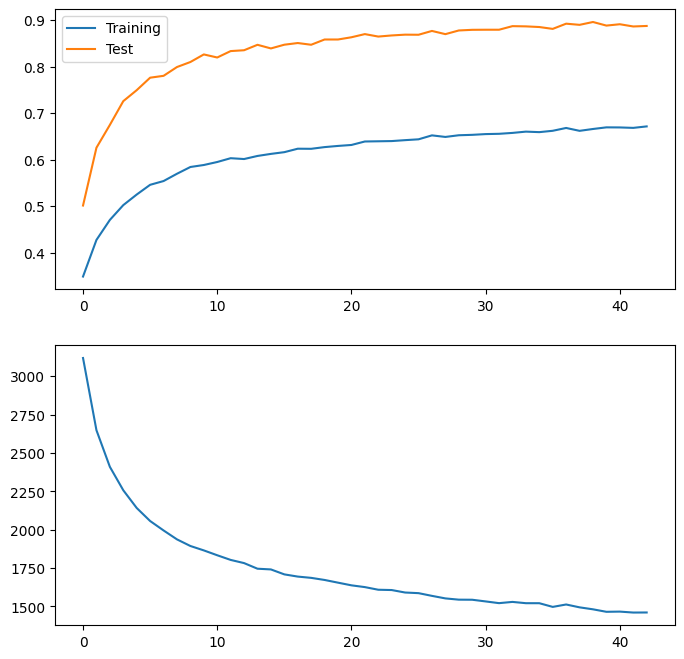

In [ ]:
# Set training parameters
device = torch.device("cuda")
max_epochs = 60
alpha = 0.001

# Initialise advanced neural net; parameters
advanced_cnn = AdvancedCNN(
    block_config
    ).to(device)
advanced_cnn.apply(weights_init)

# Train advanced CNN
adv_train_accuracy, adv_test_accuracy, adv_losses = train_network(advanced_cnn)

### Mixed kernel size

In [ ]:
block_config = {
    "block_1": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 32,
        "kernel_size": 8,
        "units": 4,
    },
    "block_2": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 28,
        "kernel_size": 7,
        "units": 4,
      },
    "block_3": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 24,
        "kernel_size": 6,
        "units": 4,
    },
    "block_4": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 4,
    },
    "block_5": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 4,
    }
}

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv2d(input, weight, bias, self.stride,
1it [03:07, 187.12s/it]


0.29728
0.4291
3221.340866088867


2it [06:12, 186.22s/it]


0.38808
0.5572
2815.742823600769


3it [09:17, 185.75s/it]


0.43504
0.6227
2562.494434118271


4it [12:22, 185.44s/it]


0.47456
0.6751
2381.515536427498


5it [15:27, 185.23s/it]


0.49518
0.7092
2279.719033241272


7it [21:37, 184.97s/it]


0.53296
0.7545
2119.7484056949615


10it [30:51, 184.82s/it]


0.56024
0.778
1954.0643277168274


13it [40:04, 184.58s/it]


0.58862
0.8152
1855.1848133206367


16it [49:19, 184.68s/it]


0.6026
0.8373
1784.2771221399307


19it [58:35, 185.02s/it]


0.61356
0.8361
1721.761386692524


22it [1:07:48, 184.79s/it]


0.6209
0.8449
1685.6435540020466


25it [1:17:05, 185.24s/it]


0.63276
0.8517
1644.232360869646


28it [1:26:21, 185.19s/it]


0.63574
0.8591
1620.2071445584297


31it [1:35:36, 185.18s/it]


0.64434
0.864
1597.929930537939


34it [1:44:52, 185.31s/it]


0.65212
0.8727
1567.1761759519577


37it [1:54:08, 185.47s/it]


0.6529
0.8717
1540.498427927494


40it [2:03:26, 185.64s/it]


0.66248
0.8787
1521.3235140144825


43it [2:12:43, 185.68s/it]


0.66074
0.8821
1496.7262484431267


46it [2:22:02, 186.20s/it]


0.66838
0.8852
1482.6549656391144


49it [2:31:20, 186.20s/it]


0.66864
0.8857
1489.2930338680744


52it [2:40:39, 186.24s/it]


0.67
0.8922
1468.5325982868671


55it [2:49:54, 185.39s/it]


0.6728
0.8924
1450.041918873787


58it [2:59:07, 184.74s/it]


0.67562
0.8921
1431.158572256565


60it [3:05:17, 185.29s/it]



    Final statistics:
      Training Accuracy: 0.67836
      Test Accuracy: 0.8944
      Loss: 1434.2685668766499
  


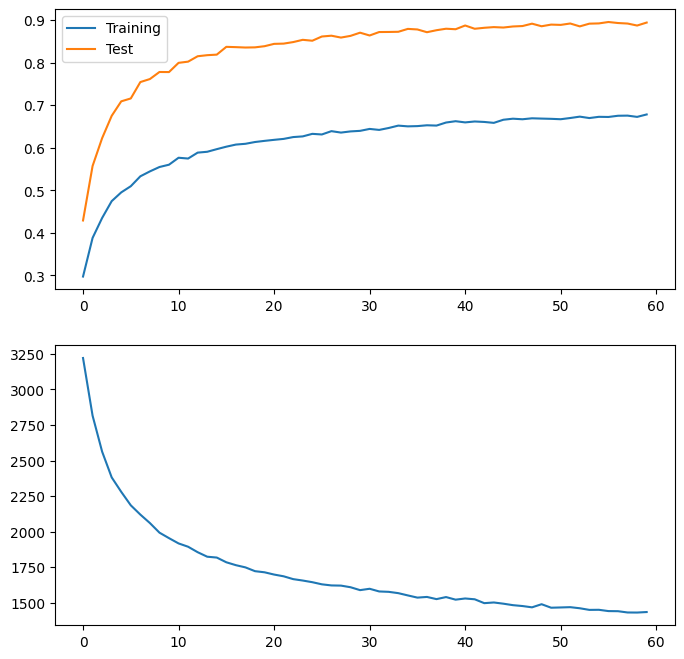

In [ ]:
# Set training parameters
device = torch.device("cuda")
max_epochs = 60
alpha = 0.001

# Initialise advanced neural net; parameters
advanced_cnn2 = AdvancedCNN(
    block_config
    ).to(device)
advanced_cnn2.apply(weights_init)

# Train advanced CNN
adv_train_accuracy, adv_test_accuracy, adv_losses = train_network(advanced_cnn2)

### Increasing units per layer

In [ ]:
block_config = {
    "block_1": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 32,
        "kernel_size": 8,
        "units": 6,
    },
    "block_2": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 28,
        "kernel_size": 7,
        "units": 6,
      },
    "block_3": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 24,
        "kernel_size": 6,
        "units": 6,
    },
    "block_4": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 6,
    },
    "block_5": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 6,
    }
}

1it [04:09, 249.38s/it]


0.29868
0.4368
3198.0016326904297


2it [08:18, 249.36s/it]


0.38922
0.5602
2787.555781841278


3it [12:28, 249.39s/it]


0.44182
0.6458
2526.5795748233795


4it [16:38, 249.74s/it]


0.46314
0.6697
2376.1174734830856


5it [20:49, 250.12s/it]


0.50144
0.7137
2272.247641324997


7it [29:10, 250.46s/it]


0.53544
0.7555
2103.59682148695


10it [41:41, 250.25s/it]


0.56004
0.7812
1939.9332354664803


13it [54:11, 250.16s/it]


0.58186
0.8173
1848.907605290413


16it [1:06:41, 250.08s/it]


0.60558
0.8203
1781.2435148358345


19it [1:19:11, 249.96s/it]


0.61348
0.8391
1719.5535755455494


22it [1:31:43, 250.33s/it]


0.62714
0.848
1678.6204717159271


25it [1:44:15, 250.47s/it]


0.63368
0.8584
1650.7460733652115


28it [1:56:46, 250.51s/it]


0.63572
0.8604
1603.438297867775


31it [2:09:18, 250.46s/it]


0.6358
0.8602
1600.6345259547234


34it [2:21:49, 250.53s/it]


0.64796
0.8692
1563.0151388943195


37it [2:34:21, 250.60s/it]


0.65054
0.8738
1541.5856222510338


39it [2:46:55, 256.81s/it]



    Final statistics:
      Training Accuracy: 0.65062
      Test Accuracy: 0.8733
      Loss: 1524.4773161709309
  


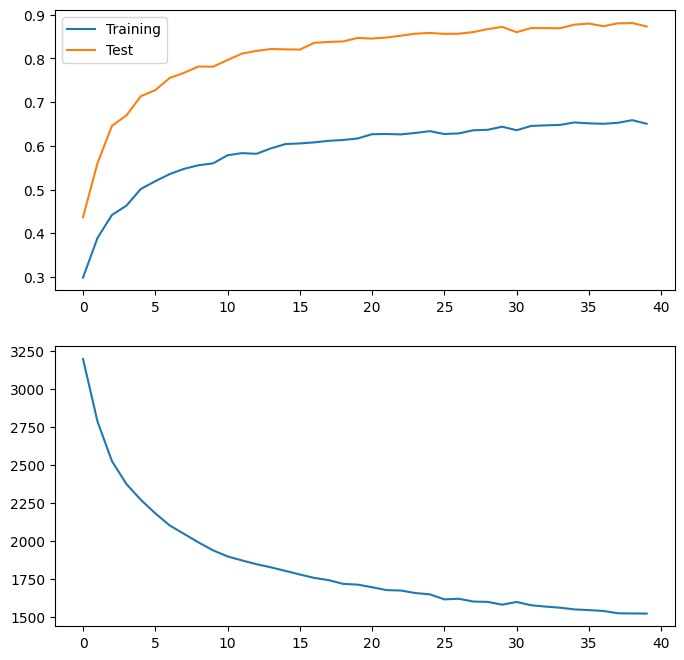

In [ ]:
# Set training parameters
device = torch.device("cuda")
max_epochs = 60
alpha = 0.001

# Initialise advanced neural net; parameters
advanced_cnn3 = AdvancedCNN(
    block_config
    ).to(device)
advanced_cnn3.apply(weights_init)

# Train advanced CNN
adv_train_accuracy, adv_test_accuracy, adv_losses = train_network(advanced_cnn3)

## Attention

In [10]:
def weights_init(net):
  """
  Init layer parameters.

  Convolutional layers:
    Weights: Kaiming Normal
    Bias: 0
  Linear Layers:
    Weights: Normal distribution with 0.001 standard deviation
    Bias: 0
  Batch Norm layers:
    Weights: 1
    Bias: 0
  """
  for m in net.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out')
        if m.bias.any():
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, std=1e-3)
        try:
          if m.bias.any():
              nn.init.constant_(m.bias, 0)
        except:
          pass

In [15]:
class Self_Attn(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(Self_Attn,self).__init__()
        self.chanel_in = in_dim
        self.activation = "gelu"

        self.query_conv = nn.Conv2d(
            in_channels = in_dim ,
            out_channels = in_dim//8 ,
            kernel_size= 1
            )
        self.key_conv = nn.Conv2d(
            in_channels = in_dim,
            out_channels = in_dim//8 ,
            kernel_size= 1
            )
        self.value_conv = nn.Conv2d(
            in_channels = in_dim ,
            out_channels = in_dim ,
            kernel_size= 1
            )
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1)

    def forward(self,x):
        """
            inputs :
                x : input feature maps( B X C X W X H)
            returns :
                out : self attention value + input feature
                attention: B X N X N (N is Width*Height)
        """
        m_batchsize,C,width ,height = x.size()
        proj_query  = self.query_conv(x).view(m_batchsize,-1,width*height).permute(0,2,1) # B X CX(N)
        proj_key =  self.key_conv(x).view(m_batchsize,-1,width*height) # B X C x (*W*H)
        energy =  torch.bmm(proj_query,proj_key) # transpose check
        attention = self.softmax(energy) # BX (N) X (N)
        proj_value = self.value_conv(x).view(m_batchsize,-1,width*height) # B X C X N

        out = torch.bmm(proj_value,attention.permute(0,2,1) )
        out = out.view(m_batchsize,C,width,height)

        out = self.gamma*out + x
        return out

class AttentionBlock(nn.Module):

  def __init__(self, in_dim, heads):
    super(AttentionBlock, self).__init__()
    assert in_dim % heads == 0
    self.dims = int(in_dim/heads)
    self.heads = heads

    self.attentions = nn.ModuleList(
        (Self_Attn(self.dims) for _ in range(self.heads))
    )

  def forward(self, x):
    out = []
    chunks = x.chunk(self.heads, dim = 1)

    for chunk, head in zip(chunks,self.attentions):
      out.append(head(chunk))

    out = torch.cat(out, dim = 1)

    return out

In [21]:
class AttentionCNN(nn.Module):

  """
  Class defining advanced convolutional architecture based on that specified in
  assignment with attention
  """

  def __init__(self, block_config):

      """
      block_config:
        Dictionary containing the configuration for each intermediate block
      """

      super(AttentionCNN, self).__init__()

      # Set up empty sequential container to iteratively add blocks based on
      # config dictionary
      self.spine = nn.Sequential()

      # Variable to track last intermediate block's output channels
      self.int_block_out = None

      # Add first intermediate block to expand channels from 3 to 256
      self.spine.append(nn.Sequential(
        IntermediateBlock(
            input_channels = 3,
            output_channels = block_config["block_1"]["input_channels"],
            output_volume = 32,
            units = 4,
            groups = False
        ),
        nn.BatchNorm2d(block_config["block_1"]["input_channels"])
        ))

      # Iterate through config dictionary and add each block to spine
      for i, block in enumerate(block_config.values()):

        self.int_block_out = block["output_channels"]

        # Add intermediate block wrapped with the residual class
        self.spine.append(
            nn.Sequential(
              Residual(
                  IntermediateBlock(**block)
                  ),
              nn.BatchNorm2d(self.int_block_out)
              )
            )

        # Add attention block
        self.spine.append(
            AttentionBlock(self.int_block_out, 4)
        )

        # Add convolutional layer wrapped with residual layer
        self.spine.append(
            nn.Sequential(
                nn.Conv2d(
                    self.int_block_out,
                    self.int_block_out,
                    kernel_size=1
                    ),
                nn.GELU(),
                nn.BatchNorm2d(self.int_block_out)
                )
            )

      # Add adaptive pooling layer to reduce each channel to a number
      # representing one feature
      self.spine.append(nn.AdaptiveAvgPool2d((1,1)))

      # Add output block
      self.spine.append(OutputBlock(self.int_block_out, 1))

  def forward(self, x):

    return self.spine(x)

In [33]:
block_config = {
    "block_1": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 32,
        "kernel_size": 8,
        "units": 4,
    },
    "block_2": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 28,
        "kernel_size": 7,
        "units": 4,
      },
    "block_3": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 24,
        "kernel_size": 6,
        "units": 4,
    },
    "block_4": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 4,
    },
    "block_5": {
        "input_channels": 256,
        "output_channels": 256,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 4,
    }
}

1it [05:34, 334.11s/it]


0.27206
0.3887
3269.978340148926


2it [11:07, 333.73s/it]


0.35482
0.5219
2862.518919467926


3it [16:41, 333.63s/it]


0.41584
0.6053
2627.2606152296066


4it [22:14, 333.51s/it]


0.436
0.6351
2503.1808363199234


5it [27:47, 333.56s/it]


0.45998
0.662
2419.7519937753677

    Final statistics:
      Training Accuracy: 0.45998
      Test Accuracy: 0.662
      Loss: 2419.7519937753677
  


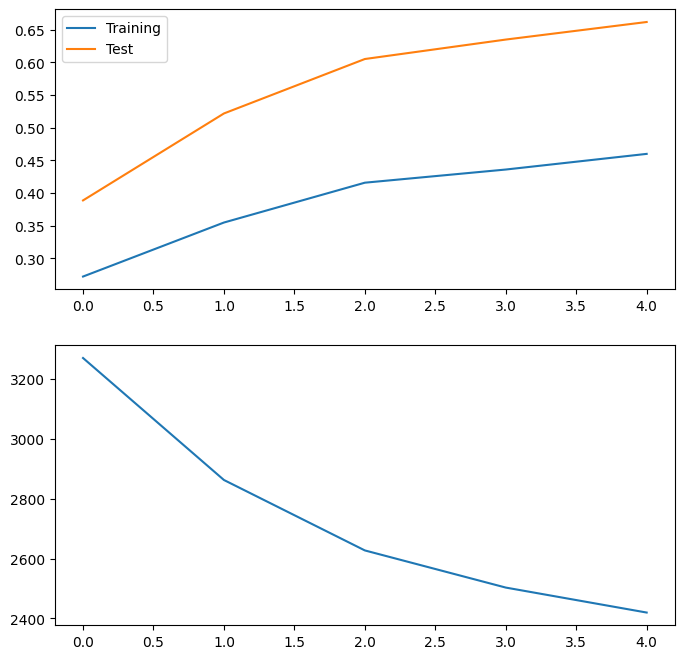

In [38]:
# Set training parameters
device = torch.device("cuda")
max_epochs = 5
alpha = 0.001

# Initialise advanced neural net; parameters
attn_cnn = AttentionCNN(
    block_config
    ).to(device)
attn_cnn.apply(weights_init)

# Train advanced CNN
attn_train_accuracy, attn_test_accuracy, attn_losses = train_network(attn_cnn)

## Increased channels

In [35]:
block_config = {
    "block_1": {
        "input_channels": 512,
        "output_channels": 512,
        "output_volume": 32,
        "kernel_size": 8,
        "units": 4,
    },
    "block_2": {
        "input_channels": 512,
        "output_channels": 512,
        "output_volume": 28,
        "kernel_size": 7,
        "units": 4,
      },
    "block_3": {
        "input_channels": 512,
        "output_channels": 512,
        "output_volume": 24,
        "kernel_size": 6,
        "units": 4,
    },
    "block_4": {
        "input_channels": 512,
        "output_channels": 512,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 4,
    },
    "block_5": {
        "input_channels": 512,
        "output_channels": 512,
        "output_volume": 20,
        "kernel_size": 5,
        "units": 4,
    }
}

1it [04:13, 253.60s/it]


0.28068
0.4109
3272.254909515381


2it [08:27, 254.06s/it]


0.38548
0.565
2816.308024406433


3it [12:42, 254.40s/it]


0.44232
0.6341
2521.8097116947174


4it [16:57, 254.42s/it]


0.47784
0.6736
2341.948076546192


5it [21:11, 254.40s/it]


0.50548
0.7146
2227.095902144909


7it [29:40, 254.40s/it]


0.55164
0.7729
2041.2666377425194


10it [42:23, 254.27s/it]


0.58394
0.8089
1866.3913081288338


13it [55:05, 254.28s/it]


0.61274
0.8362
1760.359631717205


16it [1:07:52, 255.15s/it]


0.6227
0.8473
1685.1341698765755


19it [1:20:40, 255.71s/it]


0.6337
0.8597
1638.2192041873932


22it [1:33:26, 255.53s/it]


0.64954
0.8631
1580.192011386156


25it [1:46:13, 255.72s/it]


0.65496
0.8751
1537.6900115311146


28it [1:59:00, 255.66s/it]


0.6585
0.8766
1506.2397914230824


30it [2:07:31, 255.04s/it]



    Final statistics:
      Training Accuracy: 0.66544
      Test Accuracy: 0.8855
      Loss: 1497.206023722887
  


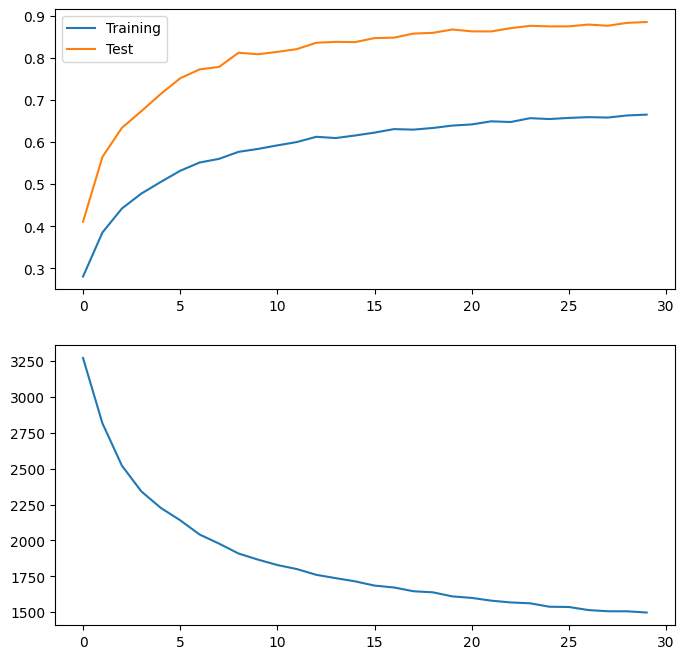

In [37]:
# Set training parameters
device = torch.device("cuda")
max_epochs = 30
alpha = 0.001

# Initialise advanced neural net; parameters
advanced_cnn4 = AdvancedCNN(
    block_config
    ).to(device)
advanced_cnn4.apply(weights_init)

# Train advanced CNN
adv_train_accuracy, adv_test_accuracy, adv_losses = train_network(advanced_cnn4)